# Training pipeline

explanation here

### Load imports

In [1]:
import numpy as np # linear algebra
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from keras.callbacks import EarlyStopping
import hopsworks

2023-01-14 17:45:09.761145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 17:45:10.443227: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-14 17:45:10.443248: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-14 17:45:12.407994: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
project = hopsworks.login()
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/4247


Connected. Call `.close()` to terminate connection gracefully.


In [3]:
try: 
    feature_view = fs.get_feature_view(name="new_electricity_data_fv", version=2)
except:
    electricity_data_fg = fs.get_feature_group('new_electricity_data_fg', version=2)
    query = electricity_data_fg.select_all()    
    feature_view = fs.create_feature_view(name="new_electricity_data_fv",
                                        version=2, # labels: "day_ahead_price"
                                        description="Read from Feature Group new_electricity_data_fg",
                                        query=query)

In [5]:
version, job = feature_view.create_training_data(
    description = 'new electricity price pred train data',
    data_format = 'csv',
    write_options = {"wait_for_job": False}
) 
print(job.id) 
# By default, it is materialised to HopsFS


Training dataset job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/4247/jobs/named/new_electricity_data_fv_2_1_create_fv_td_14012023131757/executions
17589


In [4]:
train_data = feature_view.get_training_data(training_dataset_version=1)[0]
train_data = train_data.sort_values(by=['datetime'])
train_data.set_index('datetime',inplace=True)

train_data

# train_data, test_data = feature_view.get_training_test_split(training_dataset_version=1)
# train_data, test_data = train_data.sort_values(by=['datetime']), test_data.sort_values(by=['datetime'])
# train_data

,total_generation,day_ahead_price,total_load,temperature
datetime,,,,
1640991600000,8619.0,46.60,9685.0,5.3
1640995200000,8510.0,41.33,9612.0,5.4
1640998800000,8473.0,42.18,9601.0,5.4
1641002400000,8424.0,44.37,9552.0,5.7
1641006000000,8326.0,37.67,9449.0,5.3
...,...,...,...,...
1673546400000,8811.0,98.37,11594.0,4.5
1673550000000,8749.0,74.08,11074.0,5.1
1673553600000,8708.0,74.50,10720.0,5.1


In [6]:
## Split into train & test sets
train_size = int(len(train_data) * 0.80)
test_size = len(train_data) - train_size
train = train_data.iloc[0:train_size,:]
test = train_data.iloc[train_size:,:]


In [7]:
train.head()

,total_generation,day_ahead_price,total_load,temperature
datetime,,,,
1640991600000,8619.0,46.60,9685.0,5.3
1640995200000,8510.0,41.33,9612.0,5.4
1640998800000,8473.0,42.18,9601.0,5.4
1641002400000,8424.0,44.37,9552.0,5.7
1641006000000,8326.0,37.67,9449.0,5.3


In [8]:
test.head()

,total_generation,day_ahead_price,total_load,temperature
datetime,,,,
1666904400000,7990.0,27.18,7913.0,13.3
1666908000000,8031.0,25.89,7575.0,13.8
1666911600000,7992.0,23.71,7292.0,13.7
1666915200000,7984.0,22.35,7137.0,14.0
1666918800000,7955.0,20.23,7195.0,14.2


In [9]:
# Standard scaler for features and label

sc_x=StandardScaler()
X_scaled_train=sc_x.fit_transform(train)

In [10]:
sc_y=StandardScaler()
y_scaled_train=sc_y.fit_transform(train[['day_ahead_price']])

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7195 entries, 1640991600000 to 1666900800000
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_generation  7195 non-null   float64
 1   day_ahead_price   7195 non-null   float64
 2   total_load        7195 non-null   float64
 3   temperature       7195 non-null   float64
dtypes: float64(4)
memory usage: 281.1 KB


In [12]:
step_back=24
no_records=len(train)
no_cols=len(train.columns)
X_train=[]
y_train=[]
for i in range(step_back,no_records):
    X_train.append(X_scaled_train[i-step_back:i])
    y_train.append(y_scaled_train[i][0])
X_train,y_train=np.array(X_train),np.array(y_train)

In [13]:
print(X_train.shape)
print(y_train.shape)

(7171, 24, 4)
(7171,)


In [14]:
X_train_shape=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2]))
X_train_shape.shape

(7171, 24, 4)

### LSTM model No. 1

In [15]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=665,input_shape=(step_back,no_cols),recurrent_dropout=0.2,use_bias=True),
    tf.keras.layers.Dense(units=24)
])

2023-01-14 17:46:19.383828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 17:46:19.384095: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-14 17:46:19.384839: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-14 17:46:19.385100: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-14 17:46:19.385218: W tensorflow/c

In [16]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 665)               1782200   
                                                                 
 dense (Dense)               (None, 24)                15984     
                                                                 
Total params: 1,798,184
Trainable params: 1,798,184
Non-trainable params: 0
_________________________________________________________________


In [17]:
MAX_EPOCHS = 200

def compile_and_fit(model, x_train):

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(x_train, y_train, epochs=MAX_EPOCHS,batch_size=1000, verbose=1, shuffle=False)
  return history

In [18]:
history = compile_and_fit(lstm_model, X_train_shape)

Epoch 1/200
8/8 [==============================] - 26s 3s/step - loss: 0.8137 - mean_absolute_error: 0.6762
Epoch 2/200
8/8 [==============================] - 20s 3s/step - loss: 0.6322 - mean_absolute_error: 0.5926
Epoch 3/200
8/8 [==============================] - 20s 3s/step - loss: 0.4822 - mean_absolute_error: 0.4889
Epoch 4/200
8/8 [==============================] - 21s 3s/step - loss: 0.4216 - mean_absolute_error: 0.4672
Epoch 5/200
8/8 [==============================] - 21s 3s/step - loss: 0.3498 - mean_absolute_error: 0.4119
Epoch 6/200
8/8 [==============================] - 19s 2s/step - loss: 0.2988 - mean_absolute_error: 0.3764
Epoch 7/200
8/8 [==============================] - 21s 3s/step - loss: 0.2854 - mean_absolute_error: 0.3702
Epoch 8/200
8/8 [==============================] - 20s 2s/step - loss: 0.2704 - mean_absolute_error: 0.3600
Epoch 9/200
8/8 [==============================] - 19s 2s/step - loss: 0.2203 - mean_absolute_error: 0.3201
Epoch 10/200
8/8 [==========

### LSTM model

In [31]:
#model_lstm = Sequential()
#model_lstm.add(LSTM(100, input_shape=(step_back,no_cols)))
#model_lstm.add(Dropout(0.2))
#model_lstm.add(Dense(1))
#model_lstm.compile(loss='mean_squared_error', optimizer='adam')

2023-01-13 16:44:17.854913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 16:44:17.855409: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-13 16:44:17.856003: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-13 16:44:17.856099: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-13 16:44:17.856183: W tensorflow/c

In [32]:
#model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               43600     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 43,701
Trainable params: 43,701
Non-trainable params: 0
_________________________________________________________________


In [33]:
#model_lstm.fit(X_train_shape, y_train, epochs=200, batch_size=265, verbose=1, shuffle=False)

Epoch 1/200
27/27 [==============================] - 4s 49ms/step - loss: 0.8187
Epoch 2/200
27/27 [==============================] - 1s 47ms/step - loss: 0.4697
Epoch 3/200
27/27 [==============================] - 2s 75ms/step - loss: 0.3567
Epoch 4/200
27/27 [==============================] - 1s 55ms/step - loss: 0.2888
Epoch 5/200
27/27 [==============================] - 1s 48ms/step - loss: 0.2406
Epoch 6/200
27/27 [==============================] - 1s 49ms/step - loss: 0.2105
Epoch 7/200
27/27 [==============================] - 1s 50ms/step - loss: 0.1849
Epoch 8/200
27/27 [==============================] - 1s 53ms/step - loss: 0.1626
Epoch 9/200
27/27 [==============================] - 1s 48ms/step - loss: 0.1490
Epoch 10/200
27/27 [==============================] - 1s 50ms/step - loss: 0.1400
Epoch 11/200
27/27 [==============================] - 1s 55ms/step - loss: 0.1365
Epoch 12/200
27/27 [==============================] - 1s 52ms/step - loss: 0.1292
Epoch 13/200
27/27 [=====

### Evaluate model

In [19]:
last_24=train.iloc[-step_back:]
full_df= pd.concat((last_24,test),axis=0)
print(full_df.shape)
full_df.head()

(1823, 4)


,total_generation,day_ahead_price,total_load,temperature
datetime,,,,
1666818000000,7628.0,55.18,8321.0,13.1
1666821600000,7635.0,63.60,8038.0,12.8
1666825200000,7716.0,54.81,7861.0,13.2
1666828800000,7791.0,43.26,7686.0,13.4
1666832400000,7859.0,34.98,7462.0,13.3


In [20]:
full_df=sc_x.transform(full_df)
full_df.shape

(1823, 4)

In [21]:
step_back=step_back
no_records=len(full_df)
no_cols=no_cols
X_train_shape_pred=[]
for i in range(step_back,no_records):
    X_train_shape_pred.append(full_df[i-step_back:i])
X_train_shape_pred=np.array(X_train_shape_pred)
print(X_train_shape_pred.shape)

(1799, 24, 4)


In [22]:
y_test=lstm_model.predict(X_train_shape_pred)

57/57 [==============================] - 7s 104ms/step


In [39]:
y_final_pred=sc_y.inverse_transform(y_test)
y_final_pred

array([[45.819168, 42.48201 , 46.226837, ..., 45.362785, 44.09099 ,
        44.25379 ],
       [46.460335, 42.766533, 46.349373, ..., 46.752518, 45.320656,
        44.933884],
       [40.341873, 37.244614, 39.504463, ..., 41.126816, 39.00254 ,
        38.969055],
       ...,
       [66.74877 , 63.57779 , 67.748474, ..., 66.219955, 62.954586,
        63.80565 ],
       [70.29362 , 67.33605 , 70.86142 , ..., 70.40072 , 67.45894 ,
        68.454796],
       [64.44323 , 61.49853 , 64.77788 , ..., 64.7546  , 62.304863,
        63.54052 ]], dtype=float32)

In [44]:
y_final_pred = [i[0] for i in y_final_pred]

In [31]:
final_pred=pd.DataFrame(y_final_pred)
final_pred.columns=['final_pred']
final_pred.head()

,final_pred
0,45.819168
1,46.460335
2,40.341873
3,25.111641
4,14.313446


In [32]:
test.reset_index(inplace=True)

In [33]:
fully_final=pd.concat((final_pred,test),axis=1)
fully_final

,final_pred,datetime,total_generation,day_ahead_price,total_load,temperature
0,45.819168,1666904400000,7990.0,27.18,7913.0,13.3
1,46.460335,1666908000000,8031.0,25.89,7575.0,13.8
2,40.341873,1666911600000,7992.0,23.71,7292.0,13.7
3,25.111641,1666915200000,7984.0,22.35,7137.0,14.0
4,14.313446,1666918800000,7955.0,20.23,7195.0,14.2
...,...,...,...,...,...,...
1794,98.766457,1673546400000,8811.0,98.37,11594.0,4.5
1795,83.662010,1673550000000,8749.0,74.08,11074.0,5.1
1796,66.748772,1673553600000,8708.0,74.50,10720.0,5.1
1797,70.293617,1673557200000,8665.0,66.84,10132.0,5.3


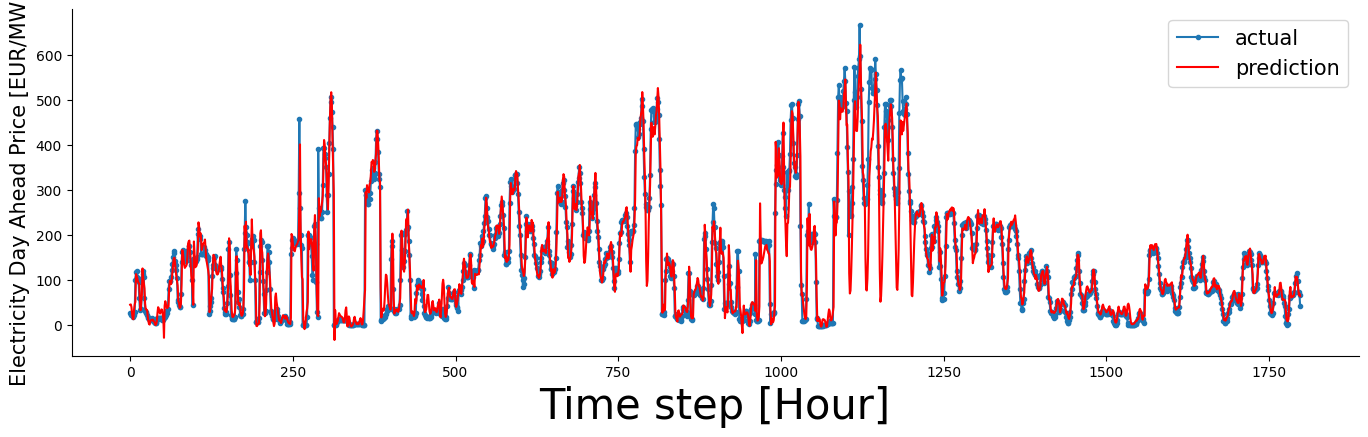

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
aa=[x for x in range(1799)]
plt.figure(figsize=(14,4))
plt.plot(aa, fully_final['day_ahead_price'], marker='.', label="actual")
plt.plot(aa, fully_final['final_pred'], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Electricity Day Ahead Price [EUR/MWh]', size=15)
plt.xlabel('Time step [Hour]', size=30)
plt.legend(fontsize=15)
plt.show();

### Upload model to hopsworks

In [35]:
project = hopsworks.login() 
mr = project.get_model_registry()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/4247
Connected. Call `.close()` to terminate connection gracefully.


In [36]:
import os
import joblib
model_dir = "model"
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

In [41]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train_shape)
output_schema = Schema(y_train)

model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)
model_schema.to_dict()

{'input_schema': {'tensor_schema': {'shape': '(7171, 24, 4)',
   'type': 'float64'}},
 'output_schema': {'tensor_schema': {'shape': '(7171, 24)',
   'type': 'float64'}}}

In [42]:
joblib.dump(lstm_model, model_dir + "/electricity_price.pkl")

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_absolute_error
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-01-14 19:44:57     21602040
config.json                                    2023-01-14 19:44:57         2525
metadata.json                                  2023-01-14 19:44:57           64


['model/electricity_price.pkl']

In [45]:
print('R2 Score: ', r2_score(fully_final['day_ahead_price'], y_final_pred)) 
print('MAE: ', mean_absolute_error(fully_final['day_ahead_price'], y_final_pred)) 
print('mean_squared_error testing : ', mean_squared_error(fully_final['day_ahead_price'], y_final_pred, squared=False))


R2 Score:  0.9061913088289225
MAE:  21.056529778880233
mean_squared_error testing :  39.661306325931136


In [46]:
model = mr.sklearn.create_model(
    name="SE3_elec_price_model",
    metrics={"mae": "21.05"},
    description="SE3 electricity price prediction",
    model_schema=model_schema,
    version=4
)

model.save('model/electricity_price.pkl')

Model export complete: 100%|██████████| 6/6 [00:32<00:00,  5.42s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/4247/models/SE3_elec_price_model/4


Model(name: 'SE3_elec_price_model', version: 4)